# Introduction

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

 # Data preparation


In [48]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

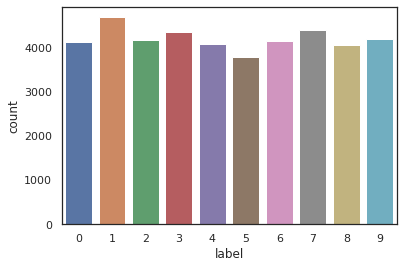

In [49]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

g = sns.countplot(Y_train)

Y_train.value_counts()

We have similar counts for the 10 digits.

## Check for null and missing values

In [50]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [51]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

we can safely go ahead.

## Normalization

In [52]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## Reshape

In [53]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Label encoding

In [54]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## Split training and valdiation set 

In [55]:
# Set the random seed
random_seed = 2

In [56]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

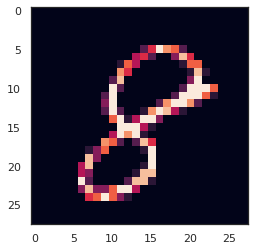

In [57]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# CNN-Define the model

In [58]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## Set the optimizer and annealer



In [59]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [60]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [61]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [62]:
epochs = 30
batch_size = 86

## Data augmentation 

In [63]:
 #Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/30
440/440 - 129s - loss: 0.2377 - accuracy: 0.9254 - val_loss: 0.0656 - val_accuracy: 0.9810
Epoch 2/30
440/440 - 126s - loss: 0.0727 - accuracy: 0.9777 - val_loss: 0.0705 - val_accuracy: 0.9831
Epoch 3/30
440/440 - 126s - loss: 0.0539 - accuracy: 0.9841 - val_loss: 0.0531 - val_accuracy: 0.9829
Epoch 4/30
440/440 - 126s - loss: 0.0461 - accuracy: 0.9861 - val_loss: 0.0487 - val_accuracy: 0.9883
Epoch 5/30
440/440 - 128s - loss: 0.0410 - accuracy: 0.9876 - val_loss: 0.0302 - val_accuracy: 0.9914
Epoch 6/30
440/440 - 129s - loss: 0.0366 - accuracy: 0.9889 - val_loss: 0.0295 - val_accuracy: 0.9907
Epoch 7/30
440/440 - 127s - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.0331 - val_accuracy: 0.9919
Epoch 8/30
440/440 - 127s - loss: 0.0305 - accuracy: 0.9910 - val_loss: 0.0347 - val_accuracy: 0.9914
Epoch 9/30
440/440 - 130s - loss: 0.0308 - accuracy: 0.9906 - val_loss: 0.0302 - val_accuracy: 0.9921
Epoch 10/30
440/440 - 130s - loss: 0.0287 - accuracy: 0.9915 - val_loss: 0.0306 - 

# Evaluate the model


## Confusion matrix

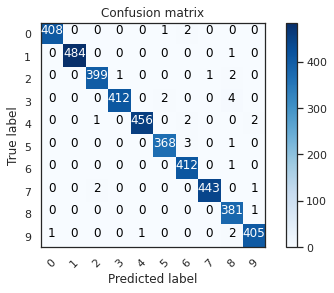

In [65]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [66]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [67]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("MNIST_submission2.csv",index=False)